In [1]:
# Check current versions
!python -c "import numpy; print('Current numpy version:', numpy.__version__)"
!python -c "import torch; print('Current torch version:', torch.__version__)"

# Install desired versions with CUDA 12.4
!pip install numpy==1.26.4
!pip install torch==2.3.0+cu124 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu124.html
!pip install torcheeg
!pip install pytorch-lightning

# This will show the versions in new Python processes
!python -c "import numpy; print('Installed numpy version:', numpy.__version__)"
!python -c "import torch; print('Installed torch version:', torch.__version__)"

print("\n*** IMPORTANT: Please restart the runtime now for changes to take effect in this notebook  (search for 'restart session' in top left 'commands' ***")

Current numpy version: 2.0.2
Current torch version: 2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 18.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==2.3.0+cu124 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2

In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    accelerator = "gpu"
    pin_memory = True
    print("GPU is available. Training will use GPU acceleration.")
else:
    accelerator = "cpu"
    pin_memory = False
    print("WARNING: GPU not available, using CPU instead")

PyTorch version: 2.6.0+cu124
CUDA version: 12.4


In [2]:
from google.colab import drive
from IPython.display import clear_output as cls

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
experiment_name = input("name your experiment (or use old one) > ")  # like sst_01

name your experiment (or use old one) > lstm_00


In [4]:
import os

IO_PATH = f'/content/drive/MyDrive/datasets/STEW/io/{experiment_name}/' # not-existant or populated - ! NOT EMPTY !
MODEL_SAVE_PATH = f'/content/drive/MyDrive/datasets/STEW/model/{experiment_name}/' # is going to be created if it doesn't exist yet
DATA_FOLDER_PATH = '/content/drive/MyDrive/datasets/STEW/dataset' # has to exist

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"model folder not existing, creating at {MODEL_SAVE_PATH}")
    os.mkdir(MODEL_SAVE_PATH)
else:
    print(f"ATTENTION: model folder already exists, only proceed if you are ready to overwrite")

if not os.path.exists(DATA_FOLDER_PATH):
    raise Exception("make sure dataset exists")


SEED:int = 42
BATCH_SIZE:int = 64
N_WORKERS:int = 2

ATTENTION: model folder already exists, only proceed if you are ready to overwrite


# loading data

In [9]:
"""
should take about a minute
"""

import os
import numpy as np
import mne
from typing import List, Dict


def load_stew_dataset(stew_path: str) -> tuple:
    subjects = set()
    for filename in os.listdir(stew_path):
        if filename.startswith('sub') and filename.endswith('.txt'):
            try:
                subject_id = int(filename[3:5])
                subjects.add(subject_id)
            except ValueError:
                continue
    subjects = sorted(list(subjects))


    raw_list = []
    info_list = []
    task_mapping = {'lo': 'low','hi': 'high'}

    ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] # correct channel names in order
    sfreq = 128 # assume sampling rate in hZ
    montage = mne.channels.make_standard_montage("standard_1020")


    for subject in subjects:
        subject_str = f"{subject:02d}" # leading zero if needed

        for task_code in ['lo', 'hi']:
            filename = f"sub{subject_str}_{task_code}.txt"
            file_path = os.path.join(stew_path, filename)

            if os.path.exists(file_path):
                eeg_data = np.loadtxt(file_path)

                info = mne.create_info(
                    ch_names=ch_names,
                    sfreq=sfreq,
                    ch_types=['eeg'] * len(ch_names)
                )

                raw = mne.io.RawArray(eeg_data.T, info)
                raw.set_montage(montage)
                raw.filter(0.5, 45)
                raw.notch_filter(50)

                metadata = {
                    'subject_id': subject,
                    'trial_id': task_code,
                    'workload_level': 0 if task_code == 'lo' else 1 # true if doing task (thus high cogload)
                }

                raw_list.append(raw)
                info_list.append(metadata)

    return raw_list, info_list


def split_raw_object(raw, clip_duration:int):
    sfreq = raw.info['sfreq']
    samples_per_clip = int(clip_duration * sfreq)

    n_samples = len(raw.times)
    n_clips = n_samples // samples_per_clip

    raw_clips = []

    for i in range(n_clips):
        start_sample = i * samples_per_clip
        end_sample = start_sample + samples_per_clip

        clip = raw.copy().crop(
            tmin=start_sample / sfreq,
            tmax=(end_sample - 1) / sfreq,
            include_tmax=True
        )

        raw_clips.append(clip)

    return raw_clips


WINDOW_SIZE = 4 # seconds

unsplit_raw_list, unsplit_info_list = load_stew_dataset(DATA_FOLDER_PATH)
raw_list = []
info_list = []


for raw, info in zip(unsplit_raw_list, unsplit_info_list):
    raws = split_raw_object(raw, WINDOW_SIZE)
    raw_list.extend(raws)
    info_list.extend([info] * len(raws))

cls()
print(f"\n\nLoaded {len(unsplit_raw_list)} recordings,  split into {len(raw_list)} clips of {str(WINDOW_SIZE)} seconds, from {len(set([info['subject_id'] for info in info_list]))} subjects")



Loaded 96 recordings,  split into 3552 clips of 4 seconds, from 48 subjects


Using matplotlib as 2D backend.


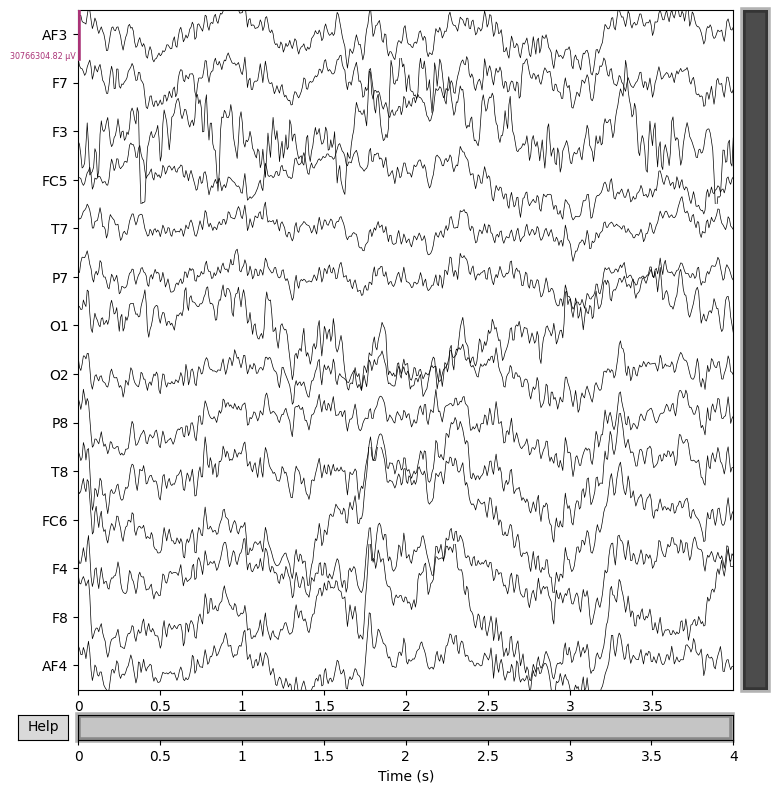

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


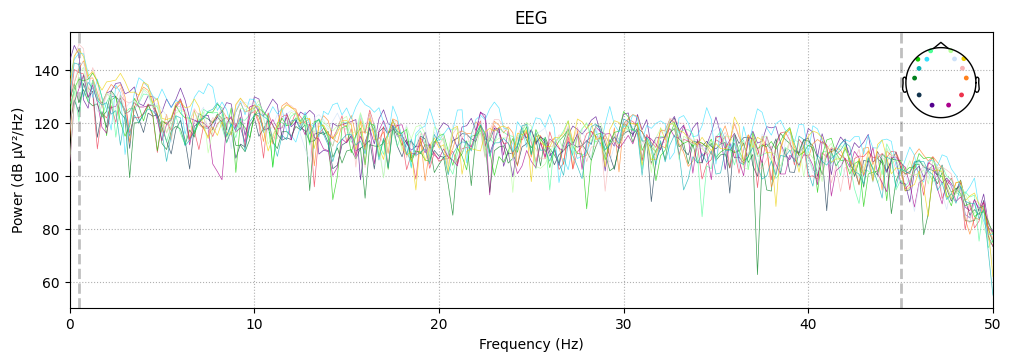

In [10]:
import random
import matplotlib.pyplot as plt

raw = random.choice(raw_list)

# plot raw graph
fig = raw.plot(duration=10, n_channels=20, scalings='auto', title='Raw Data')

# plot power spectral density
fig_psd = raw.plot_psd(fmax=50)

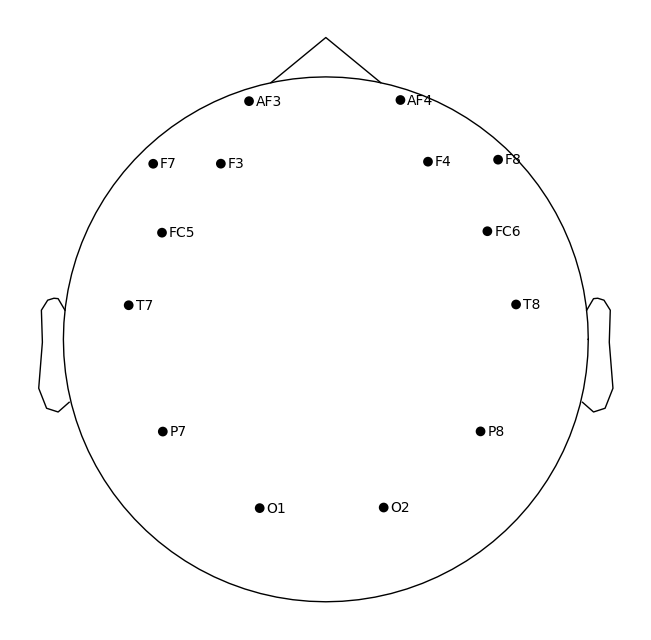

{'AF3': (-0.035186007467538326, 0.10912956509481905), 'F7': (-0.07187662505917264, 0.07310352742670875), 'F3': (-0.05180903841183724, 0.08668789888287941), 'FC5': (-0.07890597635539306, 0.05136738419239063), 'T7': (-0.08598207795805729, 0.014871638175652204), 'P7': (-0.07445796452347851, -0.042123164958505765), 'O1': (-0.03157355787465608, -0.08056835212663661), 'O2': (0.027683100559624117, -0.08048883980936473), 'P8': (0.07103247088902218, -0.04225997601209522), 'T8': (0.08326136985759491, 0.015258189278681372), 'FC6': (0.0778466192866476, 0.052098811200362666), 'F4': (0.050274277731628736, 0.08743838910239796), 'F8': (0.07143526925150917, 0.07450512647808137), 'AF4': (0.0342298581732583, 0.10981127208682755)}


In [11]:
def get_channel_locations_from_mne(raw):
    """
    make sure montage is set
    """

    pos_3d = raw.get_montage().get_positions()['ch_pos']
    ch_names = raw.ch_names

    location_dict = {}
    for ch in ch_names:
        if ch in pos_3d:
            x, y, _ = pos_3d[ch]
            location_dict[ch] = (x, y)

    return location_dict


fig_topo = raw.plot_sensors(show_names=True)
STEW_CHANNEL_LOCATION_DICT = get_channel_locations_from_mne(raw)
CHANNEL_NAMES = list(STEW_CHANNEL_LOCATION_DICT.keys())
print(STEW_CHANNEL_LOCATION_DICT)

(129, 13)


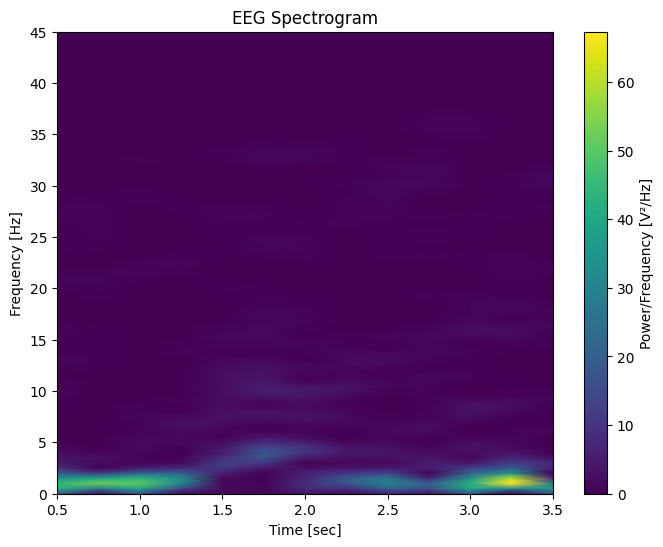

In [24]:
from scipy import signal

def create_spectogram(raw_data):
    f, t, Sxx = signal.spectrogram(
        raw_data,
        fs=128,              # Sampling rate
        nperseg=128,         # Window size (1 second at 128 Hz)
        noverlap=96,         # 75% overlap
        nfft=256,            # Length of FFT
        detrend='constant',  # Remove mean from each segment
        window='hann'        # Apply Hann window to reduce spectral leakage
    )
    return f, t, Sxx

def plot_spectogram(f, t, Sxx):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('EEG Spectrogram')
    plt.colorbar(label='Power/Frequency [V²/Hz]')
    plt.ylim(0, 45)  # Limit to frequencies below 45 Hz
    plt.show()

raw_data = raw.get_data()[0] # first channel AF3
f, t, Sxx = create_spectogram(raw_data)
print(Sxx.shape)
plot_spectogram(f, t, Sxx)

# DL using torcheeg

In [25]:
from torcheeg import transforms

FREQUENCY_BINS = 64
N_CHANNELS = len(CHANNEL_NAMES)

# our chunks are already put into 4s windows, so no need for `MapChunk`
# (paper contradicts itselft) having our normalization after the freq-extraction, normalizes each frequency by itself
# this here uses Wavelet-Tranform instead of Short-Fourier-Transform
offline_transform = transforms.Compose([
    transforms.CWTSpectrum(
        wavelet='morl',
        total_scale=FREQUENCY_BINS,
        contourf=False
    ),
    transforms.MeanStdNormalize(),
])

processed_raw = offline_transform(eeg=raw.get_data())
print(processed_raw["eeg"].shape)  # should be [channels, sample_rate x frequency_bins] (will add batch_size in pipeline) -

(14, 64, 512)


In [ ]:
from torcheeg.datasets import MNERawDataset
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from typing import Tuple


online_transform = transforms.Compose([
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Select('workload_level')
])

dataset = MNERawDataset(
    io_path=IO_PATH,

    raw_list=raw_list,
    info_list=info_list,
    chunk_size=512,  # 4 seconds at 128 Hz (better for cognitive load)
    overlap=320,     # 74% overlap

    offline_transform=offline_transform,
    online_transform=online_transform,
    label_transform=label_transform,

    num_worker=0, # don't multiprocess to avoid serialization problem
    verbose=False
)

# ---
print(f"Dataset size: {len(dataset)}")
sample = dataset[0]
eeg_data, label = sample

print(f"EEG data shape: {eeg_data.shape}")
print(f"Label: {label}")

[2025-05-01 06:10:24] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/lstm_00/.
INFO:torcheeg:🔍 | Processing EEG data. Processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/lstm_00/.
[2025-05-01 06:10:24] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
INFO:torcheeg:⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.


In [ ]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader


# validation is used during training for evaluating each batch
# test is saved to after (even if we don't train on val anyway, mechanisms like picking the best may still have 'val bias')
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Dataset split: {train_size} training, {val_size} validation, {test_size} test samples")


# ---
# when training a GPU, we put the memory on a special 'pinned' region for faster transfer between CPU and GPU
# we shuffle the data in training to avoid it learning some patterns there (across batches) - no need on eval, since metrics will be the same
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

# ---
for batch in train_loader:
    # Unpack the batch
    X, y = batch

    # Print shapes
    print(f"Input tensor shape: {X.shape}")
    print(f"Label tensor shape: {y.shape}")

    # Print label distribution
    unique_labels, counts = torch.unique(y, return_counts=True)
    print("Label distribution:")
    for label, count in zip(unique_labels.tolist(), counts.tolist()):
        print(f"  Class {label}: {count} samples ({count/len(y)*100:.2f}%)")

    # Print some additional statistics about the input data
    print(f"Input data statistics:")
    print(f"  Min value: {X.min().item():.4f}")
    print(f"  Max value: {X.max().item():.4f}")
    print(f"  Mean value: {X.mean().item():.4f}")
    print(f"  Std deviation: {X.std().item():.4f}")

    break

Dataset split: 3964 training, 849 validation, 851 test samples
Input shape: torch.Size([64, 36, 16, 16])


### initializing model

In [ ]:
from torch import nn

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=2):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x shape: [batch, channels, freq_bins, time_bins]
        batch_size, channels, freq_bins, time_bins = x.shape

        # Reshape for LSTM - each time step contains all frequency data for all channels
        x_reshaped = x.permute(0, 3, 1, 2).reshape(batch_size, time_bins, channels * freq_bins)

        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x_reshaped)

        # Use the output from the last time step
        out = self.fc(lstm_out[:, -1, :])
        return out


N_CLASSES:int = 2 # depends on your dataset, duh?
model = BiLSTMModel(input_size=N_CHANNELS, num_classes=N_CLASSES)

### actual training (don't run for inference only)

In [ ]:
from torcheeg.trainers import ClassifierTrainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

trainer = ClassifierTrainer(
    model=model,
    num_classes=N_CLASSES,
    lr=5e-5,
    weight_decay=1e-4,
    accelerator=accelerator,
    metrics=["accuracy", "precision", "recall", "f1score"]
)

callbacks = [
    # saves the best model (for recalling after plateu)
    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='best-model-{epoch:02d}-{val_accuracy:.4f}',
        monitor='val_accuracy',
        mode='max',
        save_top_k=1
    ),

    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='last-model',
        save_last=True
    ),

    # detect overfitting and end if val_accuracy stops improving for 10 epochs
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        mode='max',
        verbose=True
    )
]

In [ ]:
print("\nStarting model training...")
trainer.fit(
    train_loader,
    val_loader,
    max_epochs=100,
    default_root_dir=MODEL_SAVE_PATH,
    callbacks=callbacks,
    enable_progress_bar=True,
    enable_model_summary=True
)

# ends once the trainer is done (so most likely through EarlyStop, otherwise max_epochs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/datasets/STEW/model/sst_04 exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | SSTEmotionNet    | 525 K  | train
1 | ce_fn         | CrossEntropyLoss | 0      | train
2 | train_loss    | MeanMetric       | 0      | train
3 | val_loss      | MeanMetric       | 0      | train
4 | test_loss     | MeanMetric       | 0      | train
5 | train_metrics | MetricCollection | 0      | train
6 | val_metrics   | MetricCollection | 0      | train
7 | test_metrics  | MetricColle


Starting model training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:24:10] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.691 val_accuracy: 0.555 val_precision: 0.277 val_recall: 0.500 val_f1score: 0.357 
INFO:torcheeg:
[Val] val_loss: 0.691 val_accuracy: 0.555 val_precision: 0.277 val_recall: 0.500 val_f1score: 0.357 


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:26:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 6418.185 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 6418.185 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:26:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_accuracy improved. New best score: 0.492


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:28:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 58331392489238944546816.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 58331392489238944546816.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:28:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:30:21] INFO (torcheeg/MainThread) 
[Val] val_loss: 14862704503555096576.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 14862704503555096576.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:30:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:32:27] INFO (torcheeg/MainThread) 
[Val] val_loss: 1428728789860352.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 1428728789860352.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:32:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:34:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 90630955008.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 90630955008.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:34:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:36:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 925503.562 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 925503.562 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:36:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
print("\nEvaluating model on test set...")
test_results = trainer.test(test_loader)[0]
print(test_results)
print(f"Test accuracy: {test_results['test_accuracy']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating model on test set...


Testing: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:39:15] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.694 test_accuracy: 0.489 test_precision: 0.244 test_recall: 0.500 test_f1score: 0.328 
INFO:torcheeg:
[Test] test_loss: 0.694 test_accuracy: 0.489 test_precision: 0.244 test_recall: 0.500 test_f1score: 0.328 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4888366758823395     │
│       test_f1score        │    0.32833465933799744    │
│         test_loss         │    0.6938510537147522     │
│      test_precision       │    0.24441833794116974    │
│        test_recall        │            0.5            │
└───────────────────────────┴───────────────────────────┘

{'test_loss': 0.6938510537147522, 'test_accuracy': 0.4888366758823395, 'test_precision': 0.24441833794116974, 'test_recall': 0.5, 'test_f1score': 0.32833465933799744}
Test accuracy: 0.4888


### loading model and doing inference

In [ ]:
!pip install onnx onnxruntime

In [ ]:
import os

for fname in os.listdir(MODEL_SAVE_PATH):
    if fname.startswith("best-model") and fname.endswith(".ckpt"):
        break


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# continuing code will fail if for some reason there is no file called best-model-...ckpt
# (is automatically created due to our callbacks in training)
ckpt_path = MODEL_SAVE_PATH + fname

print(f"Loading {ckpt_path}")
checkpoint = torch.load(
    ckpt_path,
    map_location=device
)


if 'state_dict' in checkpoint:
    state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
else:
    model.load_state_dict(checkpoint)

In [ ]:
for batch in train_loader:
    dummy_input = batch[0][0:2] # take small batch of two (so the dynamic batching will work)
    print(dummy_input.shape) # torch.Size([2, 36, 16, 16])
    break



onnx_path = MODEL_SAVE_PATH + "inference.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=13,
    do_constant_folding=True,
    input_names=["eeg_input"],
    output_names=["class_probabilities"],
    dynamic_axes={
        "eeg_input": {0: "batch_size"},
        "class_probabilities": {0: "batch_size"}
    }
)

In [ ]:
#
# loading model and doing inference to check if this works
#

import onnxruntime as ort
import numpy as np


session_options = ort.SessionOptions()
session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] # fallbacks to CPU if CUDA isn't available


session = ort.InferenceSession(
    onnx_path,
    sess_options=session_options,
    providers=providers
)


input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


# numpy is more efficient that tensors, and in inference we don't need AutoGrad features
test_batch = next(iter(test_loader))
test_data, test_labels = test_batch[0], test_batch[1]
test_data_np = test_data.numpy()


onnx_outputs = session.run([output_name], {input_name: test_data_np})
probabilities = onnx_outputs[0]
predicted_classes = np.argmax(probabilities, axis=1)
print(predicted_classes)

#statistical

In [ ]:
"""
VIBE CODED https://www.nature.com/articles/s41598-024-84429-6
"""

import numpy as np
from tqdm import tqdm
from scipy import signal
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- entropy functions
def sample_entropy(x, m=2, r=0.2):
    """Calculate sample entropy of a time series"""
    n = len(x)
    if n == 0:
        return 0

    # Normalize the standard deviation to 1
    if np.std(x) > 0:
        x = (x - np.mean(x)) / np.std(x)
    else:
        return 0

    # Set r relative to the standard deviation
    r = r * np.std(x)

    # Create templates of length m and m+1
    templates_m = np.array([x[i:i+m] for i in range(n-m+1)])
    templates_m1 = np.array([x[i:i+m+1] for i in range(n-m)])

    # Count similar templates
    B = 0
    A = 0

    for i in range(n-m):
        # Count similar templates of length m
        template = templates_m[i]
        dists = np.max(np.abs(templates_m - template), axis=1)
        B += np.sum(dists < r) - 1  # Exclude self-match

        # Count similar templates of length m+1
        template = templates_m1[i]
        dists = np.max(np.abs(templates_m1 - template), axis=1)
        A += np.sum(dists < r) - 1  # Exclude self-match

    # Calculate sample entropy
    if B == 0 or A == 0:
        return 0

    return -np.log(A / B)

def fuzzy_entropy(x, m=2, r=0.2, n=2):
    """Calculate fuzzy entropy of a time series"""
    N = len(x)
    if N == 0:
        return 0

    # Normalize the standard deviation to 1
    if np.std(x) > 0:
        x = (x - np.mean(x)) / np.std(x)
    else:
        return 0

    # Set r relative to the standard deviation
    r = r * np.std(x)

    # Create templates of length m and m+1
    templates_m = np.array([x[i:i+m] for i in range(N-m+1)])
    templates_m1 = np.array([x[i:i+m+1] for i in range(N-m)])

    # Calculate similarity using fuzzy membership function
    def similarity(a, b, r):
        d = np.max(np.abs(a - b))
        return np.exp(-np.power(d, n) / r)

    # Calculate phi_m and phi_m+1
    phi_m = 0
    for i in range(N-m):
        for j in range(N-m):
            if i != j:
                phi_m += similarity(templates_m[i], templates_m[j], r)

    phi_m1 = 0
    for i in range(N-m-1):
        for j in range(N-m-1):
            if i != j:
                phi_m1 += similarity(templates_m1[i], templates_m1[j], r)

    # Avoid division by zero
    if phi_m == 0:
        return 0

    # Calculate fuzzy entropy
    return np.log(phi_m / phi_m1)

def renyi_entropy(x, alpha=2):
    """Calculate Renyi entropy of a time series"""
    # Create histogram
    hist, _ = np.histogram(x, bins=100, density=True)
    hist = hist[hist > 0]  # Remove zeros

    # Calculate Renyi entropy
    if len(hist) == 0:
        return 0

    return 1/(1-alpha) * np.log(np.sum(np.power(hist, alpha)))

def differential_entropy(x):
    """Calculate differential entropy of a time series (assuming Gaussian)"""
    if len(x) == 0 or np.std(x) <= 0:
        return 0

    # For Gaussian distribution
    return 0.5 * np.log(2 * np.pi * np.e * np.var(x))

# --- other functions
def find_extrema(signal_data):
    """Find local maxima and minima in the signal"""
    maxima_idx = signal.argrelmax(signal_data)[0]
    minima_idx = signal.argrelmin(signal_data)[0]
    extrema_idx = np.sort(np.concatenate((maxima_idx, minima_idx)))
    return extrema_idx

def compute_local_mean(signal_data, extrema_idx):
    """Compute local mean between consecutive extrema"""
    local_mean = np.zeros_like(signal_data)
    for i in range(len(extrema_idx)-1):
        start, end = extrema_idx[i], extrema_idx[i+1]
        local_mean[start:end+1] = (signal_data[start] + signal_data[end]) / 2
    return local_mean

def compute_envelope(signal_data, extrema_idx):
    """Compute envelope function"""
    envelope = np.zeros_like(signal_data)
    for i in range(len(extrema_idx)-1):
        start, end = extrema_idx[i], extrema_idx[i+1]
        envelope[start:end+1] = abs(signal_data[start] - signal_data[end]) / 2
    return envelope

# --- main RobustLocalMeanDistribution funtion (fourrier-transform alternative)
def rlmd(signal_data, max_imfs=5):
    """Robust Local Mean Decomposition"""
    imfs = []
    residual = signal_data.copy()

    for _ in range(max_imfs):
        # Initialize
        h = residual.copy()

        # Sifting process
        for _ in range(10):  # Maximum 10 iterations for sifting
            # Find extrema
            extrema_idx = find_extrema(h)
            if len(extrema_idx) <= 2:  # Not enough extrema
                break

            # Compute local mean
            m = compute_local_mean(h, extrema_idx)

            # Compute envelope
            a = compute_envelope(h, extrema_idx)

            # Update h
            s = (h - m) / (a + 1e-10)  # Avoid division by zero

            # Check if s is an IMF
            if np.all(np.abs(s) <= 1.0 + 1e-10):
                h = s
                break

            h = s

        # Extract IMF
        if len(extrema_idx) <= 2:  # Not enough extrema
            break

        # Compute envelope for final IMF
        envelope = compute_envelope(h, extrema_idx)
        imf = h * envelope
        imfs.append(imf)

        # Update residual
        residual = residual - imf

        # Check if residual is monotonic
        if len(find_extrema(residual)) <= 2:
            break

    return imfs, residual


# Feature extraction
def extract_entropy_features(imf):
    """Extract entropy features from an IMF"""
    features = {}

    # Entropy features using our custom implementations
    features['fuzzy_entropy'] = fuzzy_entropy(imf)
    features['sample_entropy'] = sample_entropy(imf)
    features['renyi_entropy'] = renyi_entropy(imf)
    features['diff_entropy'] = differential_entropy(imf)

    # Additional features
    features['skewness'] = stats.skew(imf)
    features['kurtosis'] = stats.kurtosis(imf)

    # PSD features
    f, psd = signal.welch(imf, fs=250, nperseg=min(256, len(imf)))
    features['psd_delta'] = np.sum(psd[(f >= 0.5) & (f < 4)])
    features['psd_theta'] = np.sum(psd[(f >= 4) & (f < 8)])
    features['psd_alpha'] = np.sum(psd[(f >= 8) & (f < 13)])
    features['psd_beta'] = np.sum(psd[(f >= 13) & (f < 30)])
    features['psd_gamma'] = np.sum(psd[f >= 30])

    return features

# Binary Arithmetic Optimization Algorithm for feature selection
def bao_feature_selection(X, y, max_iter=100, pop_size=20):
    """Simplified BAO for feature selection"""
    n_features = X.shape[1]

    # Initialize population with binary values
    population = np.random.randint(0, 2, size=(pop_size, n_features))

    # Best solution initialization
    best_solution = None
    best_fitness = -np.inf

    # Fitness function - higher is better
    def fitness(solution):
        if np.sum(solution) == 0:
            return -np.inf

        # Create classifier for evaluation
        clf = DecisionTreeClassifier(random_state=42)

        # Use only selected features
        X_selected = X[:, solution == 1]

        # Simple train/validation split for fitness evaluation
        X_train, X_val, y_train, y_val = train_test_split(
            X_selected, y, test_size=0.3, random_state=42
        )

        # Train and evaluate
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_val, y_val)

        # Balance accuracy with feature count
        feature_ratio = np.sum(solution) / n_features
        return 0.8 * accuracy - 0.2 * feature_ratio  # Prioritize accuracy

    for iter_idx in tqdm(range(max_iter), desc="BAO optimization"):
        # Evaluate current population
        for i in range(pop_size):
            current_fitness = fitness(population[i])
            if current_fitness > best_fitness:
                best_fitness = current_fitness
                best_solution = population[i].copy()

        # Update solutions using Lévy flight
        for i in range(pop_size):
            # Simplified Lévy flight
            levy = np.random.standard_cauchy(n_features)

            # V-shaped transfer function
            transfer_prob = np.abs(levy) / np.sqrt(1 + levy**2)

            # Update position
            for j in range(n_features):
                if np.random.rand() < transfer_prob[j]:
                    population[i, j] = 1 - population[i, j]  # Flip bit

    return best_solution

# Optimized Ensemble Learning classifier
def create_oel_classifier():
    """Create Optimized Ensemble Learning classifier"""
    # Base classifiers
    tree = DecisionTreeClassifier(max_depth=10, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)
    svm = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)

    # Voting classifier (OEL)
    oel = VotingClassifier(
        estimators=[
            ('tree', tree),
            ('knn', knn),
            ('svm', svm)
        ],
        voting='soft'  # Use probability estimates for voting
    )

    return oel

# Process MNE raw objects with workload levels from info_list
def process_raw_list_with_metadata(raw_list, info_list, window_size=4.0, step=2.0):
    """Process list of MNE raw objects with metadata"""
    all_features = []
    all_labels = []

    for raw, info in tqdm(zip(raw_list, info_list), total=len(raw_list), desc="Processing subjects"):
        # Extract workload level from metadata
        workload_level = info['workload_level']

        # Get data from raw object
        data, times = raw.get_data(return_times=True)
        sfreq = raw.info['sfreq']

        window_samples = int(window_size * sfreq)
        step_samples = int(step * sfreq)

        # Process each channel
        for ch_idx in range(data.shape[0]):
            channel_data = data[ch_idx]

            # Extract windows
            for start in range(0, len(channel_data) - window_samples, step_samples):
                segment = channel_data[start:start + window_samples]

                # Apply RLMD
                imfs, _ = rlmd(segment, max_imfs=5)

                # Extract features from each IMF
                segment_features = []
                for imf in imfs:
                    features = extract_entropy_features(imf)
                    segment_features.extend(list(features.values()))

                all_features.append(segment_features)
                all_labels.append(workload_level)

    return np.array(all_features), np.array(all_labels)

# Main function to train and evaluate the model
def train_cognitive_load_model(raw_list, info_list):
    """Train cognitive load detection model using raw_list and info_list"""
    # Process data and extract features
    X, y = process_raw_list_with_metadata(raw_list, info_list)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection using BAO
    print("Running BAO feature selection...")
    selected_features = bao_feature_selection(X_train_scaled, y_train)
    X_train_selected = X_train_scaled[:, selected_features == 1]
    X_test_selected = X_test_scaled[:, selected_features == 1]

    # Create and train OEL classifier
    print("Training OEL classifier...")
    oel = create_oel_classifier()
    oel.fit(X_train_selected, y_train)

    # Evaluate
    train_accuracy = oel.score(X_train_selected, y_train)
    test_accuracy = oel.score(X_test_selected, y_test)

    print(f"Training accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing accuracy: {test_accuracy * 100:.2f}%")

    return {
        'model': oel,
        'scaler': scaler,
        'selected_features': selected_features,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    }

In [ ]:
results = train_cognitive_load_model(raw_list, info_list)
print(results)

Processing subjects:   0%|          | 0/96 [09:47<?, ?it/s]


KeyboardInterrupt: 